In [1]:
#Import warnings
import warnings
warnings.filterwarnings('ignore')

In [92]:
# General imports
import numpy as np
import pandas as pd
import os
from pathlib import Path
import datetime
from collections import Counter

# For visualization
import plotly as pl
import hvplot.pandas
import plotly.express as px
import matplotlib.pyplot as plt

# For preprocessing ahead of running ML Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import sklearn as skl 

#For ML models
from sklearn.datasets import make_blobs, make_classification
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# For model evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [3]:
# Load the data
file_path = Path('C:/Users/esobieski/Documents/Berkeley/TeamPySpark/loans.csv')
loans_df = pd.read_csv(file_path)  
loans_df.head(5)

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,...,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL
0,1683373,Marilyn,English,Marilyn is 44 years old and is married with tw...,Marilyn is 44 years old and is married with tw...,500.0,500.0,funded,3047609.0,NaN,...,8.0,20,1,1,"#Woman-Owned Business, volunteer_pick, #Repeat...",Marilyn,female,true,monthly,field_partner
1,403440,Debbie,English,Debbie is 46 years old and lives in the Philip...,NaN,375.0,375.0,funded,1041004.0,NaN,...,11.0,9,1,1,NaN,Debbie,female,true,monthly,field_partner
2,963796,Suhudoo Ashibiti Yapala Fong Group,English,43-year-old Salamatu is a hardworking business...,43-year-old Salamatu is a hardworking business...,3675.0,3675.0,funded,2001867.0,NaN,...,6.0,132,1,1,"#Woman-Owned Business, #Parent, user_favorite","Damu, Ashetu, Azaratu, Zefatu, Azara, Arishetu...","female, female, female, female, female, female...","true, true, true, true, true, false, true, tru...",monthly,field_partner
3,338466,CELSA JULIA,Spanish,Celsa es madre soltera y desde hace varios ell...,Celsa is a single mother and for several year...,1100.0,1100.0,funded,876247.0,NaN,...,26.0,40,3,2,NaN,CELSA JULIA,female,true,monthly,field_partner
4,1049201,BLANCA CONSUELO,Spanish,Blanca de 51 años de edad vive en casa propia ...,Blanca is 51 years old and lives in her own ho...,600.0,600.0,funded,2141504.0,NaN,...,38.0,22,1,1,"#Elderly, user_favorite, #Parent, #Health and ...",BLANCA CONSUELO,female,true,monthly,field_partner


# Data Preprocessing: Exploration steps

In [4]:
# Get all column names
loans_df.columns

Index(['LOAN_ID', 'LOAN_NAME', 'ORIGINAL_LANGUAGE', 'DESCRIPTION',
       'DESCRIPTION_TRANSLATED', 'FUNDED_AMOUNT', 'LOAN_AMOUNT', 'STATUS',
       'IMAGE_ID', 'VIDEO_ID', 'ACTIVITY_NAME', 'SECTOR_NAME', 'LOAN_USE',
       'COUNTRY_CODE', 'COUNTRY_NAME', 'TOWN_NAME', 'CURRENCY_POLICY',
       'CURRENCY_EXCHANGE_COVERAGE_RATE', 'CURRENCY', 'PARTNER_ID',
       'POSTED_TIME', 'PLANNED_EXPIRATION_TIME', 'DISBURSE_TIME',
       'RAISED_TIME', 'LENDER_TERM', 'NUM_LENDERS_TOTAL',
       'NUM_JOURNAL_ENTRIES', 'NUM_BULK_ENTRIES', 'TAGS', 'BORROWER_NAMES',
       'BORROWER_GENDERS', 'BORROWER_PICTURED', 'REPAYMENT_INTERVAL',
       'DISTRIBUTION_MODEL'],
      dtype='object')

# Value Counts to Explore Columns for keeping/removal of columns

In [ ]:
# OK to keep DISTRIBUTION MODEL
clean_loans_df.DISTRIBUTION_MODEL.value_counts()

In [ ]:
# OK to keep REPAYMENT INTERVAL
clean_loans_df.REPAYMENT_INTERVAL.value_counts()

In [ ]:
# OK to keep REPAYMENT INTERVAL
clean_loans_df.STATUS.value_counts()

In [ ]:
# OK to keep ORIGINAL LANGUAGE
clean_loans_df.ORIGINAL_LANGUAGE.value_counts()

In [ ]:
# OK to REMOVE   NUMBER OF BULK ENTRIES - assume not useful
clean_loans_df.NUM_BULK_ENTRIES.value_counts()

In [ ]:
# OK to remove CURRENCY , keep COUNTRY instead
clean_loans_df.CURRENCY.value_counts()

In [ ]:
# OK to remove LOAN USE - too specific, not good for ML model, will do NLP on tags instead
clean_loans_df.LOAN_USE.value_counts()

# Calculate time elapsed and clean up time elapsed outliers

In [5]:
# Name variables to find time elapsed from when request was posted to when it was funded.
raised_time = pd.to_datetime(loans_df["RAISED_TIME"])
posted_time = pd.to_datetime(loans_df["POSTED_TIME"])
elapsed_time_df = raised_time - posted_time

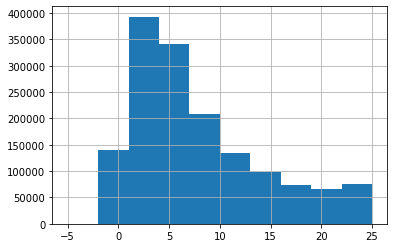

In [6]:
# Histogram of elapsed time amounts
elapsed_time_df.astype("timedelta64[D]").hist(range=[-5, 25])
# 12 days is our cutoff for logistic regression

In [7]:
# Summary stats for elapsed time
elapsed_time_df.describe()

count                    1845152
mean     12 days 12:33:57.929855
std      13 days 20:08:02.457958
min          -382 days +23:17:05
25%              3 days 10:48:29
50%       7 days 13:52:05.500000
75%             18 days 20:45:15
max            533 days 10:22:00
dtype: object

In [8]:
# There are 203 times where elapsed time is negative - REMOVE THEM BELOW
sum(elapsed_time_df < pd.to_timedelta(0))

203

In [9]:
# Display df
elapsed_time_df.head(5)

0    9 days 11:00:44
1    8 days 19:54:19
2    6 days 02:16:46
3    7 days 00:55:38
4   10 days 02:03:17
dtype: timedelta64[ns]

In [10]:
# Delete negative elapsed time
clean_elapsed_time_df = elapsed_time_df[elapsed_time_df > pd.to_timedelta(0)]

In [11]:
# Remove bad data from original dataframe using the same index, that way clean elapsed_time_df will have same number of rows
# to be merged back into dataframe
clean_loans_df = loans_df[elapsed_time_df > pd.to_timedelta(0)]

# Transform gender column into Male and Female columns with numbers not words

In [12]:
# Checking that column is still in string
loans_df["BORROWER_GENDERS"]

0                                                     female
1                                                     female
2          female, female, female, female, female, female...
3                                                     female
4                                                     female
                                 ...                        
1941976                                               female
1941977                                               female
1941978    female, female, female, male, female, female, ...
1941979       female, female, female, female, female, female
1941980                                               female
Name: BORROWER_GENDERS, Length: 1941981, dtype: object

In [13]:
# Setting up a function for converting strings to number objects
# But then group of all males and one female comes up as 1, looks like 1 single female
# KEEP IN MIND WHEN INTERPRETING RESULTS

clean_loans_df.BORROWER_GENDERS.astype(str)

test_string = "male, female, male, male, male, male"

def female(txt):
    lst = txt.split(", ")
    count = 0
    for x in lst:
        if x == "female":
            count +=1 
    return count

def male(txt):
    lst = txt.split(", ")
    count = 0
    for x in lst:
        if x == "male":
            count +=1 
    return count

female(test_string)

1

In [14]:
# Make a working copy of the loans_df dataframe
working_loans_df = clean_loans_df.copy()
working_loans_df.head(5)

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,...,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL
0,1683373,Marilyn,English,Marilyn is 44 years old and is married with tw...,Marilyn is 44 years old and is married with tw...,500.0,500.0,funded,3047609.0,NaN,...,8.0,20,1,1,"#Woman-Owned Business, volunteer_pick, #Repeat...",Marilyn,female,true,monthly,field_partner
1,403440,Debbie,English,Debbie is 46 years old and lives in the Philip...,NaN,375.0,375.0,funded,1041004.0,NaN,...,11.0,9,1,1,NaN,Debbie,female,true,monthly,field_partner
2,963796,Suhudoo Ashibiti Yapala Fong Group,English,43-year-old Salamatu is a hardworking business...,43-year-old Salamatu is a hardworking business...,3675.0,3675.0,funded,2001867.0,NaN,...,6.0,132,1,1,"#Woman-Owned Business, #Parent, user_favorite","Damu, Ashetu, Azaratu, Zefatu, Azara, Arishetu...","female, female, female, female, female, female...","true, true, true, true, true, false, true, tru...",monthly,field_partner
3,338466,CELSA JULIA,Spanish,Celsa es madre soltera y desde hace varios ell...,Celsa is a single mother and for several year...,1100.0,1100.0,funded,876247.0,NaN,...,26.0,40,3,2,NaN,CELSA JULIA,female,true,monthly,field_partner
4,1049201,BLANCA CONSUELO,Spanish,Blanca de 51 años de edad vive en casa propia ...,Blanca is 51 years old and lives in her own ho...,600.0,600.0,funded,2141504.0,NaN,...,38.0,22,1,1,"#Elderly, user_favorite, #Parent, #Health and ...",BLANCA CONSUELO,female,true,monthly,field_partner


In [15]:
# Convert the datatypes for gender to string
working_loans_df.astype(str)

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,...,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL
0,1683373,Marilyn,English,Marilyn is 44 years old and is married with tw...,Marilyn is 44 years old and is married with tw...,500.0,500.0,funded,3047609.0,nan,...,8.0,20,1,1,"#Woman-Owned Business, volunteer_pick, #Repeat...",Marilyn,female,true,monthly,field_partner
1,403440,Debbie,English,Debbie is 46 years old and lives in the Philip...,nan,375.0,375.0,funded,1041004.0,nan,...,11.0,9,1,1,nan,Debbie,female,true,monthly,field_partner
2,963796,Suhudoo Ashibiti Yapala Fong Group,English,43-year-old Salamatu is a hardworking business...,43-year-old Salamatu is a hardworking business...,3675.0,3675.0,funded,2001867.0,nan,...,6.0,132,1,1,"#Woman-Owned Business, #Parent, user_favorite","Damu, Ashetu, Azaratu, Zefatu, Azara, Arishetu...","female, female, female, female, female, female...","true, true, true, true, true, false, true, tru...",monthly,field_partner
3,338466,CELSA JULIA,Spanish,Celsa es madre soltera y desde hace varios ell...,Celsa is a single mother and for several year...,1100.0,1100.0,funded,876247.0,nan,...,26.0,40,3,2,nan,CELSA JULIA,female,true,monthly,field_partner
4,1049201,BLANCA CONSUELO,Spanish,Blanca de 51 años de edad vive en casa propia ...,Blanca is 51 years old and lives in her own ho...,600.0,600.0,funded,2141504.0,nan,...,38.0,22,1,1,"#Elderly, user_favorite, #Parent, #Health and ...",BLANCA CONSUELO,female,true,monthly,field_partner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941976,1439861,Licet Maria,Spanish,"Ella es Licet, una mujer casada de 43 años de ...","This is Licet, a married, 43 year-old woman. ...",700.0,700.0,funded,2725884.0,nan,...,14.0,28,1,1,"#Repeat Borrower, user_favorite, #Woman-Owned ...",Licet Maria,female,true,bullet,field_partner
1941977,171856,fatimata Ousmane,French,"Fatimata Ousmane S. est une femme de 58 ans, e...","Fatimata Ousmane S. is a 58 year old woman, sh...",550.0,550.0,funded,478179.0,nan,...,8.0,16,1,1,nan,fatimata Ousmane,female,true,bullet,field_partner
1941978,1415671,Yamono Group,French,Fatouma est la dame qui tient la corne du béli...,Fatouma is a 28-year-old Malian woman who is m...,3875.0,3875.0,funded,2691174.0,nan,...,10.0,135,2,1,"#Animals, #Schooling, #Woman-Owned Business, u...","Binta boureima, Salimata daouda, Fatouma amag...","female, female, female, male, female, female, ...","true, true, true, true, true, true, true, true...",bullet,field_partner
1941979,585168,Kotognogontala Iv Group,French,Les 6 membres du groupe KOTOGNOGONTALA IV sont...,The 6 members of the group Kotognogontala IV a...,475.0,475.0,funded,1391720.0,nan,...,9.0,16,2,1,nan,"ALIMA, SALI, ABI, Maminata, MASSENI, KADIA","female, female, female, female, female, female","true, true, true, true, true, true",bullet,field_partner


In [16]:
# Look at the gender column in working_loans_df
working_loans_df = clean_loans_df['BORROWER_GENDERS'].dropna()
working_loans_df

0                                                     female
1                                                     female
2          female, female, female, female, female, female...
3                                                     female
4                                                     female
                                 ...                        
1941976                                               female
1941977                                               female
1941978    female, female, female, male, female, female, ...
1941979       female, female, female, female, female, female
1941980                                               female
Name: BORROWER_GENDERS, Length: 1802001, dtype: object

In [17]:
# Apply the male and female gender functions to the dataset, yields a number value for each field. 
male_df = working_loans_df.apply(male)
female_df = working_loans_df.apply(female)
male_df.head(5)

0    0
1    0
2    0
3    0
4    0
Name: BORROWER_GENDERS, dtype: int64

# Exploration of gender columns male and female

In [ ]:
# Gender distrubtion histogram of females
female_df.hist(range=[-2, 50])

In [ ]:
# Gender distribution histogram of males 
male_df.hist(range=[-2, 50])

In [ ]:
# Check value for number of males (1.3 million borrowers have no men in the group or solo business)
clean_loans_df['MALE'].value_counts()

In [ ]:
# Check value for number of females (362 thousand borrowers have no women in the group or solo business)
clean_loans_df['FEMALE'].value_counts()

# Merge Male, Female, and Elapsed Time dataframes back into clean_loans_df

In [18]:
# Merge male into clean_loans_df 
clean_loans_df["MALE"]=male_df
# Check dataframe
clean_loans_df.head(5)

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,...,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,MALE
0,1683373,Marilyn,English,Marilyn is 44 years old and is married with tw...,Marilyn is 44 years old and is married with tw...,500.0,500.0,funded,3047609.0,NaN,...,20,1,1,"#Woman-Owned Business, volunteer_pick, #Repeat...",Marilyn,female,true,monthly,field_partner,0.0
1,403440,Debbie,English,Debbie is 46 years old and lives in the Philip...,NaN,375.0,375.0,funded,1041004.0,NaN,...,9,1,1,NaN,Debbie,female,true,monthly,field_partner,0.0
2,963796,Suhudoo Ashibiti Yapala Fong Group,English,43-year-old Salamatu is a hardworking business...,43-year-old Salamatu is a hardworking business...,3675.0,3675.0,funded,2001867.0,NaN,...,132,1,1,"#Woman-Owned Business, #Parent, user_favorite","Damu, Ashetu, Azaratu, Zefatu, Azara, Arishetu...","female, female, female, female, female, female...","true, true, true, true, true, false, true, tru...",monthly,field_partner,0.0
3,338466,CELSA JULIA,Spanish,Celsa es madre soltera y desde hace varios ell...,Celsa is a single mother and for several year...,1100.0,1100.0,funded,876247.0,NaN,...,40,3,2,NaN,CELSA JULIA,female,true,monthly,field_partner,0.0
4,1049201,BLANCA CONSUELO,Spanish,Blanca de 51 años de edad vive en casa propia ...,Blanca is 51 years old and lives in her own ho...,600.0,600.0,funded,2141504.0,NaN,...,22,1,1,"#Elderly, user_favorite, #Parent, #Health and ...",BLANCA CONSUELO,female,true,monthly,field_partner,0.0


In [19]:
# Merge Female column back into DF
clean_loans_df["FEMALE"]=female_df
# Check dataframe
clean_loans_df.head(5)

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,...,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,MALE,FEMALE
0,1683373,Marilyn,English,Marilyn is 44 years old and is married with tw...,Marilyn is 44 years old and is married with tw...,500.0,500.0,funded,3047609.0,NaN,...,1,1,"#Woman-Owned Business, volunteer_pick, #Repeat...",Marilyn,female,true,monthly,field_partner,0.0,1.0
1,403440,Debbie,English,Debbie is 46 years old and lives in the Philip...,NaN,375.0,375.0,funded,1041004.0,NaN,...,1,1,NaN,Debbie,female,true,monthly,field_partner,0.0,1.0
2,963796,Suhudoo Ashibiti Yapala Fong Group,English,43-year-old Salamatu is a hardworking business...,43-year-old Salamatu is a hardworking business...,3675.0,3675.0,funded,2001867.0,NaN,...,1,1,"#Woman-Owned Business, #Parent, user_favorite","Damu, Ashetu, Azaratu, Zefatu, Azara, Arishetu...","female, female, female, female, female, female...","true, true, true, true, true, false, true, tru...",monthly,field_partner,0.0,23.0
3,338466,CELSA JULIA,Spanish,Celsa es madre soltera y desde hace varios ell...,Celsa is a single mother and for several year...,1100.0,1100.0,funded,876247.0,NaN,...,3,2,NaN,CELSA JULIA,female,true,monthly,field_partner,0.0,1.0
4,1049201,BLANCA CONSUELO,Spanish,Blanca de 51 años de edad vive en casa propia ...,Blanca is 51 years old and lives in her own ho...,600.0,600.0,funded,2141504.0,NaN,...,1,1,"#Elderly, user_favorite, #Parent, #Health and ...",BLANCA CONSUELO,female,true,monthly,field_partner,0.0,1.0


In [20]:
# Merge Elapsed Time back into df
clean_loans_df["FUNDING_TIME"]= clean_elapsed_time_df
# Check dataframe
clean_loans_df.head(5)

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,...,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,MALE,FEMALE,FUNDING_TIME
0,1683373,Marilyn,English,Marilyn is 44 years old and is married with tw...,Marilyn is 44 years old and is married with tw...,500.0,500.0,funded,3047609.0,NaN,...,1,"#Woman-Owned Business, volunteer_pick, #Repeat...",Marilyn,female,true,monthly,field_partner,0.0,1.0,9 days 11:00:44
1,403440,Debbie,English,Debbie is 46 years old and lives in the Philip...,NaN,375.0,375.0,funded,1041004.0,NaN,...,1,NaN,Debbie,female,true,monthly,field_partner,0.0,1.0,8 days 19:54:19
2,963796,Suhudoo Ashibiti Yapala Fong Group,English,43-year-old Salamatu is a hardworking business...,43-year-old Salamatu is a hardworking business...,3675.0,3675.0,funded,2001867.0,NaN,...,1,"#Woman-Owned Business, #Parent, user_favorite","Damu, Ashetu, Azaratu, Zefatu, Azara, Arishetu...","female, female, female, female, female, female...","true, true, true, true, true, false, true, tru...",monthly,field_partner,0.0,23.0,6 days 02:16:46
3,338466,CELSA JULIA,Spanish,Celsa es madre soltera y desde hace varios ell...,Celsa is a single mother and for several year...,1100.0,1100.0,funded,876247.0,NaN,...,2,NaN,CELSA JULIA,female,true,monthly,field_partner,0.0,1.0,7 days 00:55:38
4,1049201,BLANCA CONSUELO,Spanish,Blanca de 51 años de edad vive en casa propia ...,Blanca is 51 years old and lives in her own ho...,600.0,600.0,funded,2141504.0,NaN,...,1,"#Elderly, user_favorite, #Parent, #Health and ...",BLANCA CONSUELO,female,true,monthly,field_partner,0.0,1.0,10 days 02:03:17


# Removing unnecessary and repetitive columns from dataframe

In [21]:
# Removing refunded and expired out of status.  This removes all rows that are not "funded" from the dataset.
# Thus we are only looking at the speed at which loans are funded.
clean_loans_df = clean_loans_df.loc[clean_loans_df["STATUS"]=="funded"]
clean_loans_df.head(5)

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,...,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,MALE,FEMALE,FUNDING_TIME
0,1683373,Marilyn,English,Marilyn is 44 years old and is married with tw...,Marilyn is 44 years old and is married with tw...,500.0,500.0,funded,3047609.0,NaN,...,1,"#Woman-Owned Business, volunteer_pick, #Repeat...",Marilyn,female,true,monthly,field_partner,0.0,1.0,9 days 11:00:44
1,403440,Debbie,English,Debbie is 46 years old and lives in the Philip...,NaN,375.0,375.0,funded,1041004.0,NaN,...,1,NaN,Debbie,female,true,monthly,field_partner,0.0,1.0,8 days 19:54:19
2,963796,Suhudoo Ashibiti Yapala Fong Group,English,43-year-old Salamatu is a hardworking business...,43-year-old Salamatu is a hardworking business...,3675.0,3675.0,funded,2001867.0,NaN,...,1,"#Woman-Owned Business, #Parent, user_favorite","Damu, Ashetu, Azaratu, Zefatu, Azara, Arishetu...","female, female, female, female, female, female...","true, true, true, true, true, false, true, tru...",monthly,field_partner,0.0,23.0,6 days 02:16:46
3,338466,CELSA JULIA,Spanish,Celsa es madre soltera y desde hace varios ell...,Celsa is a single mother and for several year...,1100.0,1100.0,funded,876247.0,NaN,...,2,NaN,CELSA JULIA,female,true,monthly,field_partner,0.0,1.0,7 days 00:55:38
4,1049201,BLANCA CONSUELO,Spanish,Blanca de 51 años de edad vive en casa propia ...,Blanca is 51 years old and lives in her own ho...,600.0,600.0,funded,2141504.0,NaN,...,1,"#Elderly, user_favorite, #Parent, #Health and ...",BLANCA CONSUELO,female,true,monthly,field_partner,0.0,1.0,10 days 02:03:17


In [22]:
#dropping all obviously unneeded columns 
clean_loans_df.drop(['LOAN_ID', 'LOAN_NAME', 'LOAN_AMOUNT', 'STATUS','DESCRIPTION','DESCRIPTION_TRANSLATED','IMAGE_ID', 'VIDEO_ID', 'LOAN_USE','COUNTRY_CODE', 'TOWN_NAME', 'CURRENCY_POLICY',
       'CURRENCY_EXCHANGE_COVERAGE_RATE', 'CURRENCY', 'POSTED_TIME', 'PLANNED_EXPIRATION_TIME', 'DISBURSE_TIME','RAISED_TIME', 'LENDER_TERM', 'NUM_JOURNAL_ENTRIES', 'NUM_BULK_ENTRIES', 'BORROWER_NAMES','BORROWER_GENDERS','BORROWER_PICTURED'], axis=1, inplace=True)
clean_loans_df.head(5)

,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_NAME,PARTNER_ID,NUM_LENDERS_TOTAL,TAGS,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,MALE,FEMALE,FUNDING_TIME
0,English,500.0,General Store,Retail,Philippines,145.0,20,"#Woman-Owned Business, volunteer_pick, #Repeat...",monthly,field_partner,0.0,1.0,9 days 11:00:44
1,English,375.0,Grocery Store,Food,Philippines,128.0,9,NaN,monthly,field_partner,0.0,1.0,8 days 19:54:19
2,English,3675.0,Food Market,Food,Ghana,346.0,132,"#Woman-Owned Business, #Parent, user_favorite",monthly,field_partner,0.0,23.0,6 days 02:16:46
3,Spanish,1100.0,Food,Food,Colombia,177.0,40,NaN,monthly,field_partner,0.0,1.0,7 days 00:55:38
4,Spanish,600.0,Personal Housing Expenses,Housing,El Salvador,81.0,22,"#Elderly, user_favorite, #Parent, #Health and ...",monthly,field_partner,0.0,1.0,10 days 02:03:17


# Creating a manual binary classification of time into model DF, SUCCESS is when speed of borrowing is under 12 days, 12 days or more is not successful in terms of the speed - how fast does the loan fund?

In [25]:
# make a copy of clean_loans_df
bc_model_df = clean_loans_df.copy()

In [26]:
# USE FOR BINARY CLASSIFICATION
# Preprocess FUNDING_TIME such that mean = 12 days is cutoff for successful loan funding.  
Under_12days = bc_model_df["FUNDING_TIME"] < pd.to_timedelta("12 days")
bc_model_df["SUCCESS"] = Under_12days.astype(int)

In [27]:
# REMOVE FUNDING TIME from model_df
bc_model_df.drop(['FUNDING_TIME'], axis=1, inplace=True)
bc_model_df.head()

,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_NAME,PARTNER_ID,NUM_LENDERS_TOTAL,TAGS,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,MALE,FEMALE,SUCCESS
0,English,500.0,General Store,Retail,Philippines,145.0,20,"#Woman-Owned Business, volunteer_pick, #Repeat...",monthly,field_partner,0.0,1.0,1
1,English,375.0,Grocery Store,Food,Philippines,128.0,9,NaN,monthly,field_partner,0.0,1.0,1
2,English,3675.0,Food Market,Food,Ghana,346.0,132,"#Woman-Owned Business, #Parent, user_favorite",monthly,field_partner,0.0,23.0,1
3,Spanish,1100.0,Food,Food,Colombia,177.0,40,NaN,monthly,field_partner,0.0,1.0,1
4,Spanish,600.0,Personal Housing Expenses,Housing,El Salvador,81.0,22,"#Elderly, user_favorite, #Parent, #Health and ...",monthly,field_partner,0.0,1.0,1


# Creating mc_reg_df for multiple classification (MC) models (time buckets where measure of success is speed of borrowing).  bc_model_df will be for binary classification.

In [23]:
# make a copy of clean_loans_df
mc_reg_df = clean_loans_df.copy()

In [24]:
#create bucket with time delta intervals

bins = [
    pd.Timedelta(weeks = 0),
    pd.Timedelta(weeks = 1),
    pd.Timedelta(weeks = 2),
    pd.Timedelta(weeks = 3),
    pd.Timedelta(weeks = 4),
    pd.Timedelta(weeks = 5)
]
labels = [1,2,3,4,5]
mc_reg_df["FUNDING_WEEKS"] = pd.cut(mc_reg_df["FUNDING_TIME"], bins, labels=labels)
mc_reg_df.head(5)

,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_NAME,PARTNER_ID,NUM_LENDERS_TOTAL,TAGS,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,MALE,FEMALE,FUNDING_TIME,FUNDING_WEEKS
0,English,500.0,General Store,Retail,Philippines,145.0,20,"#Woman-Owned Business, volunteer_pick, #Repeat...",monthly,field_partner,0.0,1.0,9 days 11:00:44,2
1,English,375.0,Grocery Store,Food,Philippines,128.0,9,NaN,monthly,field_partner,0.0,1.0,8 days 19:54:19,2
2,English,3675.0,Food Market,Food,Ghana,346.0,132,"#Woman-Owned Business, #Parent, user_favorite",monthly,field_partner,0.0,23.0,6 days 02:16:46,1
3,Spanish,1100.0,Food,Food,Colombia,177.0,40,NaN,monthly,field_partner,0.0,1.0,7 days 00:55:38,2
4,Spanish,600.0,Personal Housing Expenses,Housing,El Salvador,81.0,22,"#Elderly, user_favorite, #Parent, #Health and ...",monthly,field_partner,0.0,1.0,10 days 02:03:17,2


In [ ]:
# REMOVE FUNDING_TIME column from mc_reg_df
mc_reg_df.drop(['FUNDING_TIME'], axis=1, inplace=True)
mc_reg_df.head(5)

# Preparing separate Dataframe for Binary Classification NLP on CoLab via exported CSV

In [53]:
# Make a copy of clean_loans_df for export to NLP projec
tags_df = bc_model_df.copy()
tags_df.head(5)

,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_NAME,PARTNER_ID,NUM_LENDERS_TOTAL,TAGS,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,MALE,FEMALE,SUCCESS
0,English,500.0,General Store,Retail,Philippines,145.0,20,"#Woman-Owned Business, volunteer_pick, #Repeat...",monthly,field_partner,0.0,1.0,1
1,English,375.0,Grocery Store,Food,Philippines,128.0,9,NaN,monthly,field_partner,0.0,1.0,1
2,English,3675.0,Food Market,Food,Ghana,346.0,132,"#Woman-Owned Business, #Parent, user_favorite",monthly,field_partner,0.0,23.0,1
3,Spanish,1100.0,Food,Food,Colombia,177.0,40,NaN,monthly,field_partner,0.0,1.0,1
4,Spanish,600.0,Personal Housing Expenses,Housing,El Salvador,81.0,22,"#Elderly, user_favorite, #Parent, #Health and ...",monthly,field_partner,0.0,1.0,1


In [54]:
# Get NLP column names
tags_df.columns

Index(['ORIGINAL_LANGUAGE', 'FUNDED_AMOUNT', 'ACTIVITY_NAME', 'SECTOR_NAME',
       'COUNTRY_NAME', 'PARTNER_ID', 'NUM_LENDERS_TOTAL', 'TAGS',
       'REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL', 'MALE', 'FEMALE',
       'SUCCESS'],
      dtype='object')

In [56]:
# Drop all columns except TAGS
tags_df.drop(['ORIGINAL_LANGUAGE', 'FUNDED_AMOUNT', 'ACTIVITY_NAME','SECTOR_NAME', 'COUNTRY_NAME', 'PARTNER_ID', 'NUM_LENDERS_TOTAL','REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL', 'MALE', 'FEMALE', 'SUCCESS'], axis=1, inplace=True)
tags_df.head(5)

,TAGS
0,"#Woman-Owned Business, volunteer_pick, #Repeat..."
1,NaN
2,"#Woman-Owned Business, #Parent, user_favorite"
3,NaN
4,"#Elderly, user_favorite, #Parent, #Health and ..."


In [57]:
# Drop rows with null values in bc_df
tags_df.dropna(axis=0, how="any", inplace=True)
tags_df.head(5)

,TAGS
0,"#Woman-Owned Business, volunteer_pick, #Repeat..."
2,"#Woman-Owned Business, #Parent, user_favorite"
4,"#Elderly, user_favorite, #Parent, #Health and ..."
6,"#Vegan, #Woman-Owned Business"
7,"#Woman-Owned Business, #Parent"


In [58]:
# Save to csv file
tags_df.to_csv("tags.csv")

# Preparing separate Dataframe for Binary Classification NLP on CoLab via exported CSV

In [45]:
# Make a copy of clean_loans_df for export to NLP projec
bc_nlp_df = bc_model_df.copy()
bc_nlp_df.head(5)

,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_NAME,PARTNER_ID,NUM_LENDERS_TOTAL,TAGS,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,MALE,FEMALE,SUCCESS
0,English,500.0,General Store,Retail,Philippines,145.0,20,"#Woman-Owned Business, volunteer_pick, #Repeat...",monthly,field_partner,0.0,1.0,1
1,English,375.0,Grocery Store,Food,Philippines,128.0,9,NaN,monthly,field_partner,0.0,1.0,1
2,English,3675.0,Food Market,Food,Ghana,346.0,132,"#Woman-Owned Business, #Parent, user_favorite",monthly,field_partner,0.0,23.0,1
3,Spanish,1100.0,Food,Food,Colombia,177.0,40,NaN,monthly,field_partner,0.0,1.0,1
4,Spanish,600.0,Personal Housing Expenses,Housing,El Salvador,81.0,22,"#Elderly, user_favorite, #Parent, #Health and ...",monthly,field_partner,0.0,1.0,1


In [46]:
# Get NLP column names
bc_nlp_df.columns

Index(['ORIGINAL_LANGUAGE', 'FUNDED_AMOUNT', 'ACTIVITY_NAME', 'SECTOR_NAME',
       'COUNTRY_NAME', 'PARTNER_ID', 'NUM_LENDERS_TOTAL', 'TAGS',
       'REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL', 'MALE', 'FEMALE',
       'SUCCESS'],
      dtype='object')

In [47]:
bc_nlp_df.drop(['ORIGINAL_LANGUAGE', 'FUNDED_AMOUNT', 'ACTIVITY_NAME','SECTOR_NAME', 'COUNTRY_NAME', 'PARTNER_ID', 'NUM_LENDERS_TOTAL','REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL', 'MALE', 'FEMALE'], axis=1, inplace=True)
bc_nlp_df.head(5)

,TAGS,SUCCESS
0,"#Woman-Owned Business, volunteer_pick, #Repeat...",1
1,NaN,1
2,"#Woman-Owned Business, #Parent, user_favorite",1
3,NaN,1
4,"#Elderly, user_favorite, #Parent, #Health and ...",1


In [48]:
# Save to csv file
bc_nlp_df.to_csv("bc_nlp.csv")

# Preparing separate Dataframe for Multiple Classification NLP on CoLab via exported CSV

In [32]:
# Make a copy of mc_reg_df for export to NLP project
mc_nlp_df = mc_reg_df.copy()
mc_nlp_df.head(5)

,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_NAME,PARTNER_ID,NUM_LENDERS_TOTAL,TAGS,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,MALE,FEMALE,FUNDING_TIME,FUNDING_WEEKS
0,English,500.0,General Store,Retail,Philippines,145.0,20,"#Woman-Owned Business, volunteer_pick, #Repeat...",monthly,field_partner,0.0,1.0,9 days 11:00:44,2
1,English,375.0,Grocery Store,Food,Philippines,128.0,9,NaN,monthly,field_partner,0.0,1.0,8 days 19:54:19,2
2,English,3675.0,Food Market,Food,Ghana,346.0,132,"#Woman-Owned Business, #Parent, user_favorite",monthly,field_partner,0.0,23.0,6 days 02:16:46,1
3,Spanish,1100.0,Food,Food,Colombia,177.0,40,NaN,monthly,field_partner,0.0,1.0,7 days 00:55:38,2
4,Spanish,600.0,Personal Housing Expenses,Housing,El Salvador,81.0,22,"#Elderly, user_favorite, #Parent, #Health and ...",monthly,field_partner,0.0,1.0,10 days 02:03:17,2


In [33]:
# Get NLP column names
mc_nlp_df.columns

Index(['ORIGINAL_LANGUAGE', 'FUNDED_AMOUNT', 'ACTIVITY_NAME', 'SECTOR_NAME',
       'COUNTRY_NAME', 'PARTNER_ID', 'NUM_LENDERS_TOTAL', 'TAGS',
       'REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL', 'MALE', 'FEMALE',
       'FUNDING_TIME', 'FUNDING_WEEKS'],
      dtype='object')

In [34]:
mc_nlp_df.drop(['ORIGINAL_LANGUAGE', 'FUNDED_AMOUNT', 'ACTIVITY_NAME','SECTOR_NAME', 'COUNTRY_NAME', 'PARTNER_ID', 'NUM_LENDERS_TOTAL','REPAYMENT_INTERVAL', 'DISTRIBUTION_MODEL', 'MALE', 'FEMALE'], axis=1, inplace=True)
mc_nlp_df.head(5)

,TAGS,FUNDING_TIME,FUNDING_WEEKS
0,"#Woman-Owned Business, volunteer_pick, #Repeat...",9 days 11:00:44,2
1,NaN,8 days 19:54:19,2
2,"#Woman-Owned Business, #Parent, user_favorite",6 days 02:16:46,1
3,NaN,7 days 00:55:38,2
4,"#Elderly, user_favorite, #Parent, #Health and ...",10 days 02:03:17,2


In [38]:
# Save to csv file
mc_nlp_df.to_csv("mc_nlp.csv")

In [39]:
mc_nlp_df.head(5)

,TAGS,FUNDING_WEEKS
0,"#Woman-Owned Business, volunteer_pick, #Repeat...",2
1,NaN,2
2,"#Woman-Owned Business, #Parent, user_favorite",1
3,NaN,2
4,"#Elderly, user_favorite, #Parent, #Health and ...",2


# Remove Tags after creating both NLP CSVs

In [59]:
#dropping TAGS column from BINARY classification
bc_model_df.drop(['TAGS'], axis=1, inplace=True)
bc_model_df.head(5)

,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_NAME,PARTNER_ID,NUM_LENDERS_TOTAL,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,MALE,FEMALE,SUCCESS
0,English,500.0,General Store,Retail,Philippines,145.0,20,monthly,field_partner,0.0,1.0,1
1,English,375.0,Grocery Store,Food,Philippines,128.0,9,monthly,field_partner,0.0,1.0,1
2,English,3675.0,Food Market,Food,Ghana,346.0,132,monthly,field_partner,0.0,23.0,1
3,Spanish,1100.0,Food,Food,Colombia,177.0,40,monthly,field_partner,0.0,1.0,1
4,Spanish,600.0,Personal Housing Expenses,Housing,El Salvador,81.0,22,monthly,field_partner,0.0,1.0,1


In [60]:
#dropping TAGS column from MULTIPLE classification
mc_reg_df.drop(['TAGS'], axis=1, inplace=True)
mc_reg_df.head(5)

,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_NAME,PARTNER_ID,NUM_LENDERS_TOTAL,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,MALE,FEMALE,FUNDING_TIME,FUNDING_WEEKS
0,English,500.0,General Store,Retail,Philippines,145.0,20,monthly,field_partner,0.0,1.0,9 days 11:00:44,2
1,English,375.0,Grocery Store,Food,Philippines,128.0,9,monthly,field_partner,0.0,1.0,8 days 19:54:19,2
2,English,3675.0,Food Market,Food,Ghana,346.0,132,monthly,field_partner,0.0,23.0,6 days 02:16:46,1
3,Spanish,1100.0,Food,Food,Colombia,177.0,40,monthly,field_partner,0.0,1.0,7 days 00:55:38,2
4,Spanish,600.0,Personal Housing Expenses,Housing,El Salvador,81.0,22,monthly,field_partner,0.0,1.0,10 days 02:03:17,2


# Prepare both BC and MC dataframes for ML through sampling

In [61]:
#pick a sample of the data as using all did not work for get dummies (3% used) - not as much needed as only BC
bc_df = bc_model_df.sample(frac =.03)

In [62]:
#pick a sample of the data as using all did not work for get dummies (6% used)
mc_df = mc_reg_df.sample(frac =.06)

# Remove null values from sampled BC and MC dataframes

In [63]:
# See how many NaNs are in bc_df
bc_df.isnull().any(axis=1)

664162     False
1419782    False
1832455    False
1567905    False
1684807    False
           ...  
1615685    False
1599297    False
931736     False
655962     False
1729113    False
Length: 55160, dtype: bool

In [64]:
# See how many NaNs are in mc_df
mc_df.isnull().any(axis=1)

361051     False
932280     False
1256756    False
1037009    False
1004477    False
           ...  
720008     False
572820     False
498191      True
1644359    False
1503253    False
Length: 110320, dtype: bool

In [65]:
# Drop rows with null values in bc_df
bc_df.dropna(axis=0, how="any", inplace=True)

In [66]:
# Drop rows with null values in mc_df
mc_df.dropna(axis=0, how="any", inplace=True)

In [67]:
# Show final bc_df
bc_df.head(5)

,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_NAME,PARTNER_ID,NUM_LENDERS_TOTAL,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,MALE,FEMALE,SUCCESS
664162,Spanish,1000.0,Blacksmith,Manufacturing,El Salvador,167.0,29,monthly,field_partner,1.0,0.0,1
1419782,Spanish,275.0,Food,Food,Colombia,154.0,11,monthly,field_partner,1.0,0.0,0
1832455,English,575.0,Food Production/Sales,Food,Philippines,145.0,7,monthly,field_partner,0.0,1.0,1
1567905,English,375.0,Pigs,Agriculture,Philippines,125.0,15,bullet,field_partner,0.0,1.0,1
1684807,English,500.0,Farming,Agriculture,Cambodia,9.0,16,monthly,field_partner,0.0,1.0,1


In [78]:
# Show final mc_df
mc_df.head(5)

,ORIGINAL_LANGUAGE,FUNDED_AMOUNT,ACTIVITY_NAME,SECTOR_NAME,COUNTRY_NAME,PARTNER_ID,NUM_LENDERS_TOTAL,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,MALE,FEMALE,FUNDING_TIME,FUNDING_WEEKS
361051,English,475.0,Grocery Store,Food,Nepal,62.0,18,monthly,field_partner,0.0,1.0,3 days 08:02:16,1
932280,Spanish,1200.0,Restaurant,Food,Peru,119.0,21,monthly,field_partner,0.0,1.0,8 days 10:54:22,2
1256756,English,325.0,General Store,Retail,Philippines,145.0,11,monthly,field_partner,0.0,1.0,11 days 09:08:22,2
1037009,English,100.0,Home Appliances,Personal Use,Cambodia,311.0,4,monthly,field_partner,0.0,2.0,5 days 21:06:21,1
1004477,English,175.0,Personal Housing Expenses,Housing,Philippines,145.0,5,monthly,field_partner,0.0,1.0,6 days 21:22:50,1


# Prepare data for machine learning models that will use binary classification

For logistic regression, our binary classification is that a successful borrowing event results in full funding within 12 days.  An unsucessful event would be funding taking longer than 12 days, as a reflection of less lender enthusiasm to fund the loan.  This removes the issue in the data that 99%+ of loans get funded and thus the data is very unbalanced if you just look at funding vs didn't fund.  

In [69]:
# Create our features  NOT SURE ABOUT THIS VS THE TRAINING AND TESTING A FEW CELLS DOWN

X = bc_df.copy()
X = X.drop('SUCCESS', axis=1)

# Create our target
y = bc_df[['SUCCESS']]

In [70]:
# Describe X  -- MOST BORROWERS ARE SOLO FEMALES

X.describe()

,FUNDED_AMOUNT,PARTNER_ID,NUM_LENDERS_TOTAL,MALE,FEMALE
count,53575.000000,53575.000000,53575.000000,53575.000000,53575.000000
mean,768.119459,165.634064,21.249183,0.378236,1.593075
std,971.919006,104.625996,26.486265,1.012829,2.989553
min,25.000000,4.000000,1.000000,0.000000,0.000000
25%,275.000000,109.000000,8.000000,0.000000,1.000000
50%,500.000000,145.000000,14.000000,0.000000,1.000000
75%,925.000000,185.000000,26.000000,1.000000,1.000000
max,50000.000000,607.000000,1688.000000,22.000000,50.000000


In [71]:
# List out y

y

,SUCCESS
664162,1
1419782,0
1832455,1
1567905,1
1684807,1
...,...
1615685,1
1599297,1
931736,0
655962,1


In [72]:
# Check the balance of our target values  
# Used a calculated value of TIME TO FULL FUNDING using date stamps in prep for LOGISTIC REGRESSION
# SUCCESS is funding in 12 days or less

y['SUCCESS'].value_counts()

1    34379
0    19196
Name: SUCCESS, dtype: int64

In [73]:
# Encode Labels (DO WE USE THIS OR ONE HOT ENCODER?)

X = pd.get_dummies(X)
X.head()

,FUNDED_AMOUNT,PARTNER_ID,NUM_LENDERS_TOTAL,MALE,FEMALE,ORIGINAL_LANGUAGE_Arabic,ORIGINAL_LANGUAGE_English,ORIGINAL_LANGUAGE_French,ORIGINAL_LANGUAGE_Indonesian,ORIGINAL_LANGUAGE_Portuguese,...,COUNTRY_NAME_Ukraine,COUNTRY_NAME_United States,COUNTRY_NAME_Vietnam,COUNTRY_NAME_Yemen,COUNTRY_NAME_Zambia,COUNTRY_NAME_Zimbabwe,REPAYMENT_INTERVAL_bullet,REPAYMENT_INTERVAL_irregular,REPAYMENT_INTERVAL_monthly,DISTRIBUTION_MODEL_field_partner
664162,1000.0,167.0,29,1.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1419782,275.0,154.0,11,1.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1832455,575.0,145.0,7,0.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1567905,375.0,125.0,15,0.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1684807,500.0,9.0,16,0.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [74]:
# ADD TRAIN-TEST SPLIT AFTER GETTING DUMMIES AND BEFORE SCALING, SO RIGHT HERE
# Dataset is split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
    y, random_state=1, stratify=y)

In [75]:
# SCALING X_TRAIN STEP 
X_train_scaled = StandardScaler().fit_transform(X_train)
print(X_train_scaled[0:5])

[[ 0.13311107  0.11058396 -0.37879648 ... -0.20713247  0.3931413
   0.        ]
 [-0.54934516 -0.31014936 -0.45267862 ... -0.20713247  0.3931413
   0.        ]
 [-0.37241206 -0.40577057 -0.26797328 ... -0.20713247 -2.54361472
   0.        ]
 [-0.19547897 -0.48226754 -0.08326795 ... -0.20713247  0.3931413
   0.        ]
 [-0.27130744 -0.53964026 -0.34185542 ... -0.20713247  0.3931413
   0.        ]]


In [76]:
# SCALING X_TEST STEP HERE 
X_test_scaled = StandardScaler().fit_transform(X_test)
print(X_test_scaled[0:5])

[[-0.50892834  0.00734418 -0.5368801  ... -0.2102466   0.3926292
   0.        ]
 [ 1.34192561 -0.82312734  2.22165439 ... -0.2102466   0.3926292
   0.        ]
 [ 0.22596955  0.10280067  0.63955373 ... -0.2102466   0.3926292
   0.        ]
 [-0.0734333  -0.57494045  0.11218684 ... -0.2102466   0.3926292
   0.        ]
 [ 0.19875111  3.87333226 -0.13121326 ... -0.2102466   0.3926292
   0.        ]]


# Prepare and scale data for machine learning models that will use multiple classification

For linear regression, Random Forest and Neural nets, we use buckets of time, 1, 2, 3, 4, and 5 weeks, so that it can both classify and be continuous.  This is our mc_df.  We notate all these with mc in front so we can run either pre-prepared through multiple models below.

In [79]:
# Create our features  NOT SURE ABOUT THIS VS THE TRAINING AND TESTING A FEW CELLS DOWN

mcX = mc_df.copy()
mcX = mcX.drop('FUNDING_WEEKS', axis=1)

# Create our target
mcy = mc_df[['FUNDING_WEEKS']]

In [80]:
# Describe X  -- MOST BORROWERS ARE SOLO FEMALES

mcX.describe()

,FUNDED_AMOUNT,PARTNER_ID,NUM_LENDERS_TOTAL,MALE,FEMALE,FUNDING_TIME
count,101920.000000,101920.000000,101920.000000,101920.000000,101920.000000,101920
mean,753.114943,166.136901,20.805426,0.360469,1.590434,10 days 16:09:15.868779
std,1026.177614,105.415407,27.450506,0.991935,2.966237,9 days 16:07:02.807962
min,25.000000,4.000000,1.000000,0.000000,0.000000,0 days 00:04:26
25%,275.000000,109.000000,7.000000,0.000000,1.000000,3 days 07:20:58
50%,475.000000,145.000000,14.000000,0.000000,1.000000,6 days 23:41:02
75%,900.000000,185.000000,25.000000,0.000000,1.000000,15 days 18:06:14.500000
max,100000.000000,607.000000,2964.000000,36.000000,48.000000,34 days 23:58:15


In [81]:
# List out y

mcy

,FUNDING_WEEKS
361051,1
932280,2
1256756,2
1037009,1
1004477,1
...,...
631284,5
720008,2
572820,2
1644359,1


In [82]:
# Check the balance of our target values  
# Used a calculated value of TIME TO FULL FUNDING using date stamps in prep for LOGISTIC REGRESSION
# SUCCESS is funding in 12 days or less

mcy['FUNDING_WEEKS'].value_counts()

1    51022
2    22234
3    10418
5    10353
4     7893
Name: FUNDING_WEEKS, dtype: int64

In [ ]:
# Encode Labels (DO WE USE THIS OR ONE HOT ENCODER?)

mcX = pd.get_dummies(mcX)
mcX.head()

# QUESTION BELOW ******************

In [91]:
# ADD TRAIN-TEST SPLIT AFTER GETTING DUMMIES AND BEFORE SCALING, SO RIGHT HERE  ****SHOULD I HAVE mcy or just y as output???????
# Dataset is split into training and testing sets
mcX_train, mcX_test, mcy_train, mcy_test = train_test_split(mcX,
    mcy, random_state=1, stratify=mcy)

ValueError: Found input variables with inconsistent numbers of samples: [53575, 101920]

In [ ]:
# SCALING X_TRAIN STEP 
mcX_train_scaled = StandardScaler().fit_transform(mcX_train)
print(mcX_train_scaled[0:5])

In [ ]:
# SCALING X_TEST STEP HERE 
mcX_test_scaled = StandardScaler().fit_transform(mcX_test)
print(mcX_test_scaled[0:5])

# Run PCA on Binary Classification model

In [85]:
# PCA model intialization 277 columns, reducing complexity
pca = PCA(n_components=32)

In [86]:
# PCA fit and transform for training
train_loans_pca = pca.fit_transform(X_train_scaled)

In [87]:
# Transform testing data using PCA to a DataFrame 
test_loans_pca = pca.transform(X_test_scaled)
X_test_pca_df = pd.DataFrame(data=test_loans_pca)
X_test_pca_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.557180,-0.306215,-2.652525,-0.027562,-0.960440,-1.158358,-0.892041,0.078076,0.282266,-0.270267,...,1.560080,-0.236585,-1.953583,0.062447,-1.212342,0.192864,0.327407,-0.311692,0.229104,0.019711
1,-0.360336,0.554261,2.641671,2.482312,1.659398,0.378317,-0.397540,2.075502,2.003181,-0.227278,...,-1.131765,-1.095417,0.491460,2.752730,-3.083853,-0.268000,-1.953934,1.862807,-2.632670,0.837638
2,0.814390,-1.140847,-1.031210,0.112807,0.210283,-0.487042,-0.453865,0.514226,0.079276,0.048946,...,1.030139,0.060537,0.685406,0.037304,-1.035709,0.547961,-0.034911,-1.226071,-0.147513,-0.070302
3,-1.236095,-0.003309,1.903107,2.033019,0.126720,-0.347002,-1.633482,2.493180,-1.989676,-1.318508,...,-1.398683,0.809919,-1.406614,1.222032,-2.422494,-1.081269,6.453760,-0.605414,-0.405142,-0.363931
4,0.927606,0.851466,1.886012,-4.652769,-0.815177,-1.327991,0.722031,-0.524113,-3.910789,-0.065793,...,-0.798205,0.974952,-0.783448,1.130577,0.851795,1.452589,-0.531271,-1.276464,1.824427,0.618634


In [88]:
# transform PCA data to a DataFrame 
X_train_pca_df = pd.DataFrame(data=train_loans_pca)
X_train_pca_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.278291,2.078724,-2.504815,0.150714,-0.650687,0.946507,-1.866903,0.000887,0.855216,0.324985,...,0.099693,1.768942,-0.125614,1.158081,-1.033908,1.383617,0.045496,-4.430865,-0.087707,1.970936
1,-1.223764,0.183352,-0.240469,-0.815562,0.850427,2.000021,-0.806800,-0.477304,0.080943,-0.350273,...,-0.019749,0.151444,-1.789762,0.012082,0.430730,-0.781257,0.511140,-1.573880,-1.182370,0.995245
2,-0.034446,-3.377273,-1.486058,-0.822552,1.021381,0.193734,0.359642,0.369642,0.528676,0.152490,...,0.222402,-0.093145,0.984178,-0.627713,-0.454676,-0.279104,0.003712,0.303222,0.128500,0.229153
3,-0.912698,0.247476,2.083229,3.676114,2.206204,0.675386,0.280903,-2.909233,1.006149,2.478765,...,0.854024,1.254574,-0.135143,-3.646413,-0.349222,0.251781,1.078954,-3.575672,1.301290,-0.792301
4,-0.197606,-1.958912,0.064805,0.704592,-0.414962,-0.438766,-0.288614,-0.563034,0.274108,-0.005531,...,0.979081,-0.228865,1.158461,-0.057512,-0.934366,0.561676,0.725027,-0.216568,0.392610,0.623962


In [89]:
# See explained variance ratio sum - Optimized to explain as much as possible - 225 components is ideal at 95%, no one feature explains 
# All features are equally important  - 10 features = 9%  - 100 features 50%  -
# Mostly linear relationship number of features and explainabilty
# PCA DID NOT HELP, WHEN IT REDUCES THE NUMBER OF FEATURES IT ALSO REDUCES EXPLAINABILITY IN A NEARLY LINEAR RELATIONSHIP
# THIS ALSO SHOWED UP IN THE ML MODELS, WHERE USING X-SCALED WAS BETTER THAN THE PCA VERSION.
sum(pca.explained_variance_ratio_)

0.2187242966350385

# Run PCA on Multiple Classification model

In [ ]:
# PCA model intialization 272 variables, reducing complexity
mc_pca = PCA(n_components=32)

In [ ]:
# PCA fit and transform for training
mc_train_loans_pca = mc_pca.fit_transform(mcX_train_scaled)

In [ ]:
# Transform testing data using PCA to a DataFrame 
mc_test_loans_pca = mc_pca.transform(mcX_test_scaled)
mc_X_test_pca_df = pd.DataFrame(data=mc_test_loans_pca)
mc_X_test_pca_df.head(5)

In [ ]:
# transform PCA data to a DataFrame 
mcX_train_pca_df = pd.DataFrame(data=mc_train_loans_pca)
mcX_train_pca_df.head(5)

In [ ]:
# See explained variance ratio sum - Optimized to explain as much as possible - 225 components is ideal at 95%, no one feature explains 
# All features are equally important  - 10 features = 9%  - 100 features 50%  -
# Mostly linear relationship number of features and explainabilty
# PCA DID NOT HELP, WHEN IT REDUCES THE NUMBER OF FEATURES IT ALSO REDUCES EXPLAINABILITY IN A NEARLY LINEAR RELATIONSHIP
# THIS ALSO SHOWED UP IN THE ML MODELS, WHERE USING X-SCALED WAS BETTER THAN THE PCA VERSION.
sum(mc_pca.explained_variance_ratio_)

# Linear Regression using Multiple Classification buckets as a continuous series

# QUESTIONS HERE TOO

In [ ]:
# ????? DO I DO THIS WITHOUT THE SCALED DATA?  Unspecified number of rows, non-scaled data has 
mcX = mc_df.YearsExperience.values.reshape(-1, 1)  # NEED TO CHANGE SECOND NUMBER TO NUMBER OF COLUMNS, scaled, dummies, pca???

In [ ]:
# Look at first 5 entries in X
mcX[:5]

In [ ]:
# Look at shape of x, ie number of rows and columns
mcX.shape

In [ ]:
# Set the target, the dependent variable, to FUNDING_WEEKS (pre-dummies????  OTHERWISE TOO MANY Ys, but pre-dummies) ????????
mcy = mc_df.FUNDING_WEEKS

In [ ]:
model = LinearRegression()

In [ ]:
model.fit(X, y)

In [ ]:
y_pred = model.predict(mcX)
print(y_pred.shape)

In [ ]:
# WHAT OTHER STATISTICS CAN I RUN AND PRINT?????  CORRELATIONS?  PLOT?
print(model.coef_)
print(model.intercept_)

# Run Logistic Regression on SUCCESS and Analyze Results

In [ ]:
# A synthetic dataset is generated with Scikit-learn’s make_blobs module
X, y = make_blobs(centers=2, random_state=42)

print(f"Labels: {y[:10]}")
print(f"Data: {X[:10]}")

In [ ]:
# dataset is visualized
plt.scatter(X[:, 0], X[:, 1], c=y)

In [ ]:
# Instantiate a Logistic Regression Model, Step 1 of 2
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier

In [ ]:
# Instantiate a Logistic Regression Model, Step 2 of 2
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
   intercept_scaling=1, l1_ratio=None, max_iter=100,
   multi_class='warn', n_jobs=None, penalty='12',
   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
   warm_start=False)

In [ ]:
# Train the Logistic Regression Model  - Using scaled data takes prediction accuracy from 66% to 69%
classifier.fit(X_train_scaled, y_train)

In [ ]:
# Validate the Logistic Regression Model
y_pred = classifier.predict(X_test_scaled)

In [ ]:
# Step 2 run predictions
pd.DataFrame({"Prediction": y_pred, "Actual": y_test["SUCCESS"]})

In [ ]:
# Evaluate Model Performance
accuracy_score(y_test, y_pred)

In [ ]:
# Run Confusion Matrix to determine the biggest factors of a fast funding loan
matrix = confusion_matrix(y_test,  y_pred)
print(matrix)

In [ ]:
# Run Classification Report
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
# TRY OUT NEW DATA -- DO WE NEED THIS STEP??? ????????????????????????????????????????
# predictions = classifier.predict(new_data)
# print("Classes are either 0 (Fast) or 1 (Slow)")
# print(f"The new point was classified as: {predictions}")

# Run SVMs using linear kernel as well as Radical Basis Kernel SVM and Analyze Results.  Tried incorporating PCA but results worsened. 

In [ ]:
# Import the SVC module from Scikit-learn, and instantiate it using linear for the orientation of the hyperplane 68% accuracy
model = SVC(kernel='linear')  

In [ ]:
# Use Radical Basis Kernel SVM *** THIS STEP TAKES 20 MINUTES ***  64.5% accuracy, commented out as Linear SVC above is more accurate

# C_2d_range = [1e-2, 1, 1e2]
# gamma_2d_range = [1e-1, 1, 1e1]
# classifiers = []
# for C in C_2d_range:
#     for gamma in gamma_2d_range:
#         clf = SVC(C=C, gamma=gamma)
#         clf.fit(X_train_scaled, y_train)
#         classifiers.append((C, gamma, clf))

In [ ]:
# Fit the model
model.fit(X_train_scaled, y_train)

In [ ]:
y_pred = model.predict(X_test_scaled)
results = pd.DataFrame({"Prediction": y_pred,"Actual": y_test["SUCCESS"]}).reset_index(drop=True)
results.head(5)

In [ ]:
# Assess the Accuracy Score
accuracy_score(y_test, y_pred)

In [ ]:
# Run the Confusion Matrix
confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

# Random Forest Model on Binary Classification

# QUESTIONS on how to tune

In [ ]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=100, random_state=78, max_depth=5) # goal is to add more here...

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, 
# min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, 
# random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None

# >>> X, y = make_classification(n_samples=1000, n_features=4,
# ...                            n_informative=2, n_redundant=0,
# ...                            random_state=0, shuffle=False)
# >>> clf = RandomForestClassifier(max_depth=2, random_state=0)
# >>> clf.fit(X, y)
# RandomForestClassifier(...)
# >>> print(clf.predict([[0, 0, 0, 0]]))

# see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
# Making predictions using the testing data.
y_pred = rf_model.predict(X_test_scaled)

In [ ]:
# Look at Importance of Each Parameter  ****NEED TO DO THIS*****
# rf_getparams

In [ ]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, y_pred)
acc_score

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

In [ ]:
# Displaying results  ********ECHO************ HELP ME MAKE ALL THESE THE SAME FOR ALL MODELS ************
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))

# Random Forest Model on Multiple Classification

# QUESTIONS on how to tune, also on inputs

Random Forest may work better looking at buckets of time and what impacts speed of funding a loan

In [ ]:
# Create a random forest classifier.
mc_rf_model = RandomForestClassifier(n_estimators=100, random_state=78, max_depth=5) # goal is to add more here...

# Fitting the model
mc_rf_model = mc_rf_model.fit(mcX_train_scaled, mcy_train)

# RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, 
# min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, 
# random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None

# >>> X, y = make_classification(n_samples=1000, n_features=4,
# ...                            n_informative=2, n_redundant=0,
# ...                            random_state=0, shuffle=False)
# >>> clf = RandomForestClassifier(max_depth=2, random_state=0)
# >>> clf.fit(X, y)
# RandomForestClassifier(...)
# >>> print(clf.predict([[0, 0, 0, 0]]))

# see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
# Making predictions using the testing data.
mcy_pred = mc_rf_model.predict(mcX_test_scaled)

In [ ]:
# Look at Importance of Each Parameter  ****NEED TO DO THIS*****
# rf_getparams

In [ ]:
# Calculating the accuracy score.
acc_score = accuracy_score(mcy_test, mcy_pred)
acc_score

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(mcy_test, mcy_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

In [ ]:
# Displaying results  ********ECHO************ HELP ME MAKE ALL THESE THE SAME FOR ALL MODELS ************
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(mcy_test, mcy_pred))

# Run Neural nets using mc_df, multiple classification

# QUESTIONS ABOUND!

In [ ]:
# Generate dummy dataset  -- OUT OF WHAT??????????????????  SHOULD I USE MY PREVIOUS GET DUMMIES?????
mcX, mcy = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=78)

# Creating a DataFrame with the dummy data
nn_df = pd.DataFrame(mcX, columns=["Feature 1", "Feature 2"])  # HOW MANY COLUMNS?????
mm_df["Target"] = y

# Plotting the dummy data
nn_df.plot.scatter(x="Feature 1", y="Feature 2", c="Target", colormap="winter")

In [ ]:
# Use sklearn to split dataset    --  COMMENTED OUT BECAUSE ALREADY SPLIT ONCE ABOVE IN DATA PREPROCESSING

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
# ALSO ALREADY SCALED DATA ABOVE

In [ ]:
# Create the Keras Sequential model. Sequential groups a linear stack of layers
nn_model = tf.keras.models.Sequential()

In [ ]:
# Add our first and only Dense layer, including the input layer  (relu between zero and infinity.  
# signmoid activation for S curve b/t 0-1 - could use with bc), or Linear function
nn_model.add(tf.keras.layers.Dense(units=1, activation="relu", input_dim=2))

In [ ]:
# Add the output layer that uses a probability activation function
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [ ]:
# Check the structure of the Sequential model
nn_model.summary()

In [ ]:
# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Fit the model to the training data
fit_model = nn_model.fit(mcX_train_scaled, mcy_train, epochs=100)

In [ ]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

In [ ]:
# Plot the accuracy
history_df.plot(y="accuracy")

In [ ]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# Predict the classification of a new set of blob data
new_X, new_Y = make_blobs(n_samples=10, centers=2, n_features=2, random_state=78)
new_X_scaled = X_scaler.transform(new_X)
nn_model.predict_classes(new_X_scaled)